In [1]:
import pandas as pd
from IPython.display import display, HTML
import numpy as np
from sklearn.utils import resample
from IPython.display import display
import numpy as np

# Create a connection with SQL server to get data.
def exec_sql_query(query, param=None):
    
    from sqlalchemy import create_engine
    import urllib
    params = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};SERVER=LAPTOP-C3LFVOFI;DATABASE=student_life;UID=student_sense;PWD=abhinav123")
    engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)
    connection = engine.raw_connection()
    
    try:
        cursor = connection.cursor()
        if(param):
            cursor.execute(query, param)
        else : 
            cursor.execute(query)
            
        results = cursor.fetchall()
        columns = [column[0] for column in cursor.description]
        df = pd.DataFrame.from_records(results, columns=columns)
        cursor.close()
        connection.commit()
    finally:
        connection.close()
    
    del engine
    return df

In [2]:
# Fetching EMA data from SQL.
sql = "Exec get_avg_stress_levels"
stress_level = exec_sql_query(sql)
stress_level.date = pd.to_datetime(stress_level.date) 

C:\Users\Abhinav Shaw\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
C:\Users\Abhinav Shaw\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


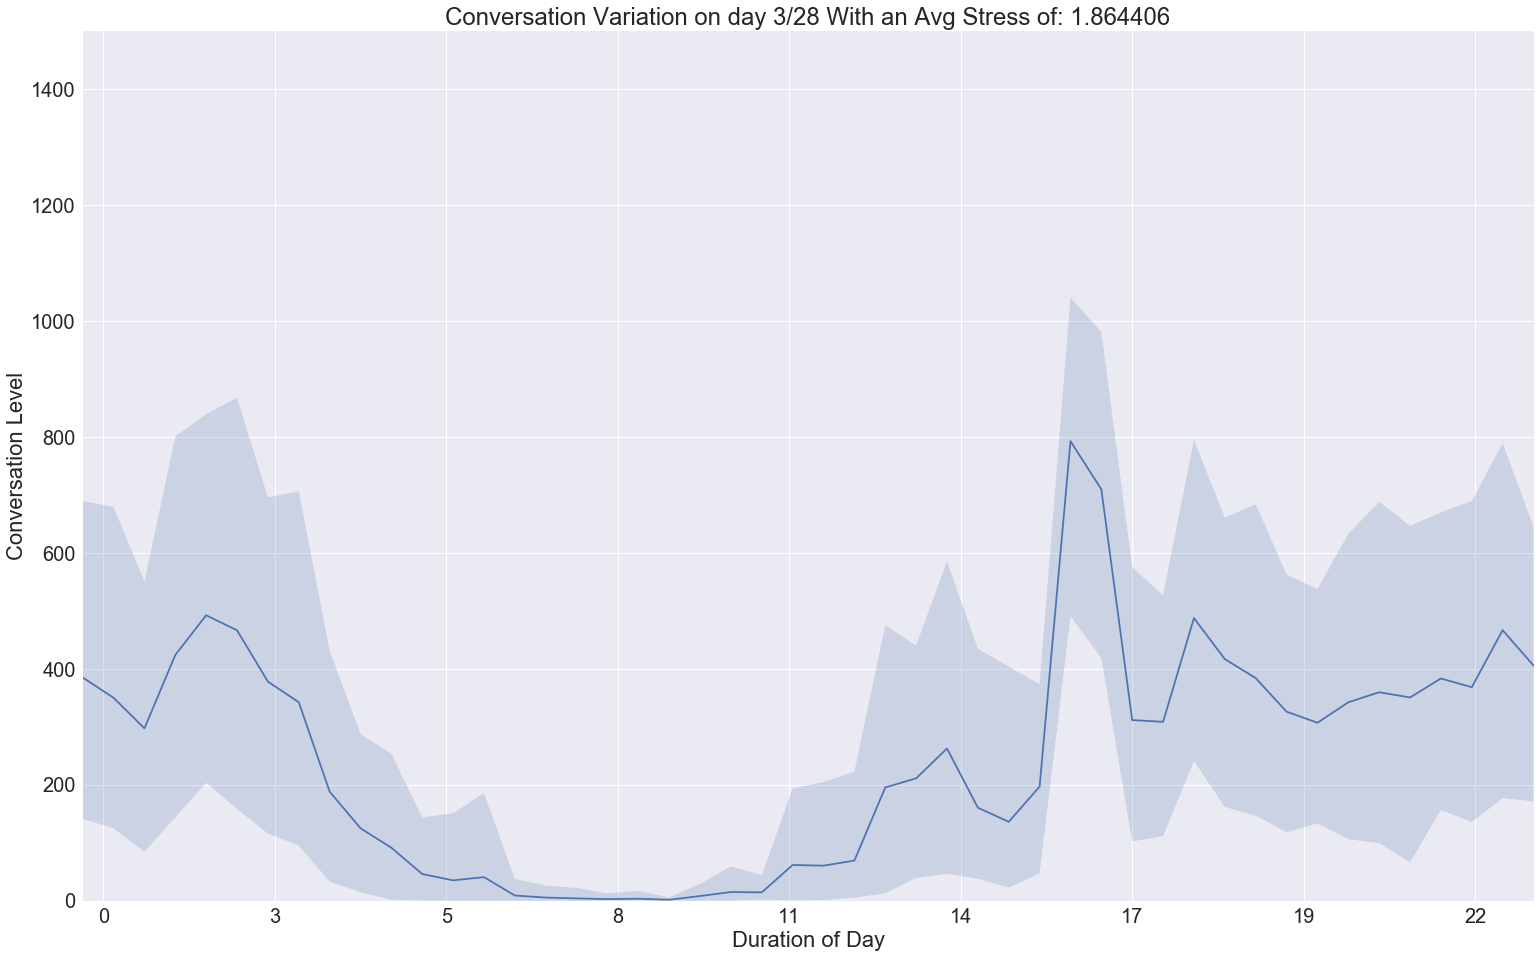

In [4]:
import pandas as pd
import os
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

start_date = datetime.datetime.strptime('24-03-13', '%d-%m-%y')
end_date = datetime.datetime.strptime('08-05-13', '%d-%m-%y')

def myFormatter(x, pos):

    date_f = pd.to_datetime(x, infer_datetime_format=True)
#     print(x, date_f)
    return  str(date_f.hour) 

for day_offset in range(4,5):
    
    # Least stressed day
    stress_day =  start_date + datetime.timedelta(days=day_offset)

    os.chdir('F:\Projects\DataProcessor\StudentLife Data')

    dir_list  = [folder for folder in  os.listdir() if 'student' in folder ]  

    audio_details_final = pd.DataFrame()


    for folder in dir_list:    

        file_name = folder+"\\audio_details_train_x.csv"

        if os.path.exists(file_name):
            audio_details = pd.read_csv(file_name, index_col=0, infer_datetime_format=True, parse_dates=[1])
        else:
            continue
        
        audio_details = audio_details.loc[:, ['time', 'student_id', 'audio_activity_inference']]
        
        
        bool_1 =  audio_details['time']  < stress_day + datetime.timedelta(days=1)
        bool_2 =  audio_details['time']  >= stress_day 
        audio_details = audio_details[np.logical_and(bool_1, bool_2)]
        
        # selecting only conversations and silence
        audio_details = audio_details[np.logical_and(audio_details['audio_activity_inference']  != 2,audio_details['audio_activity_inference']  != 3)]
        
        audio_details_gen = audio_details.groupby(pd.Grouper(key='time', freq='30T')).sum()
        audio_details_gen.reset_index(inplace=True)
        audio_details_gen.reset_index(inplace=True)
#         display(audio_details_gen)
        
        if len(audio_details_gen) < 48:
            continue

        audio_details_final = audio_details_final.append(audio_details_gen, ignore_index=True) 
        
    audio_details_final['unit'] = audio_details_final.groupby('time').cumcount()+1
    audio_details_final.fillna(value = 0, inplace=True)
    
    #Extracting avg stress on all student that day.
    avg_stress = stress_level[stress_level["date"] == stress_day]['avg_stress_level']
    avg_stress = avg_stress.values[0]
    
    # Plotting the values.
    fig, ax = plt.subplots(figsize=(26,16))
    sns.set(font_scale = 2)
    sns.set_style("darkgrid")
    ax = sns.tsplot(data=audio_details_final, time='time', value='audio_activity_inference',  unit='unit', ci=[100], ax=ax)
    ax.set_ylim((0,1500))
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(myFormatter))
    ax.set_title("Conversation Variation on day "+str(stress_day.month) +"/"+str(stress_day.day)+ " With an Avg Stress of: "+ str(avg_stress))
    ax.set_xlabel('Duration of Day')
    ax.set_ylabel("Conversation Level")
    plt.savefig("F:\\Projects\\StudentLife-ML-Analysis\\Vizualization\\Plots\\ConversationViz\\Conversation_viz_all_studs_day_"+  str(day_offset)  +".jpg")